In [300]:
import nltk
nltk.download('senseval')
from nltk.corpus import senseval
from nltk import NaiveBayesClassifier
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package senseval to
[nltk_data]     C:\Users\Sandu\AppData\Roaming\nltk_data...
[nltk_data]   Package senseval is already up-to-date!


In [301]:
dataset=senseval.instances('interest.pos')

number of senses: 6
class distribution {'interest_1': 361, 'interest_2': 11, 'interest_3': 66, 'interest_4': 178, 'interest_5': 500, 'interest_6': 1252}


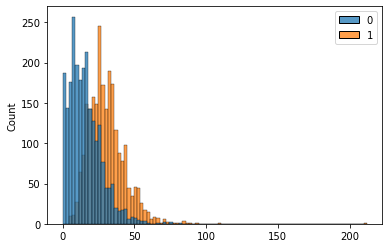

In [303]:
# some data analysis
senses = set()
position = []
length = []
dic = {'interest_1':0,
      'interest_2':0,
      'interest_3':0,
      'interest_4':0,
      'interest_5':0,
      'interest_6':0}
for instance in dataset:
    senses.add(instance.senses)
    position.append(instance.position)
    length.append(len(instance.context))
    dic[instance.senses[0]] +=1
    
sns.histplot((position,length))
print('number of senses:',len(senses))
print('class distribution',dic)

In [304]:
def get_features(instance):
    def process(sentence):
        
        # transform from treebank tagging to wordnet compatible
        def get_wordnet_pos(treebank_tag):
            if treebank_tag.startswith('J'):
                return wordnet.ADJ
            elif treebank_tag.startswith('V'):
                return wordnet.VERB
            elif treebank_tag.startswith('N'):
                return wordnet.NOUN
            elif treebank_tag.startswith('R'):
                return wordnet.ADV
            else:
                return ''
            
        lemmatizer = WordNetLemmatizer() 
        # tuple (lemmatized word, pos tag)
        return [(lemmatizer.lemmatize(pair[0].lower(), get_wordnet_pos(pair[1])),get_wordnet_pos(pair[1])) for pair in sentence if get_wordnet_pos(pair[1])!='']
    
    features={}
#     features['position'] = instance.position
#     features['length'] = len(instance.context)
    try:
        features['prev'] = instance.context[instance.position-1][0]
        features['next'] = instance.context[instance.position+1][0]
        sent = process(instance.context)
        x = sent.index(('interest', 'n'))
        features['prevlem'] = sent[x-1][0]
        features['nextlem'] = sent[x+1][0]
        features['prevlem2'] = sent[x-2][0]
        features['nextlem2'] = sent[x+2][0]
    except:
        pass
    return features
    

get_features(dataset[0])

{'prev': 'in',
 'next': 'rates',
 'prevlem': 'decline',
 'nextlem': 'rate',
 'prevlem2': 'further'}

In [305]:
def make_dataset(dataset):
    length = len(dataset)
    train_set = []
    test_set = []
    for i in dataset[:int(length/100*90)]:
        train_set.append((get_features(i),i.senses[0]))
    for i in dataset[int(length/100*90):]:
        test_set.append((get_features(i),i.senses[0]))
    return train_set, test_set

train_set,test_set=make_dataset(dataset)
cls = NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(cls, test_set))
print(cls.show_most_informative_features())

0.8860759493670886
Most Informative Features
                 nextlem = 'rate'         intere : intere =    201.3 : 1.0
                    next = 'in'           intere : intere =     63.6 : 1.0
                 prevlem = 'have'         intere : intere =     49.9 : 1.0
                    prev = 'other'        intere : intere =     48.2 : 1.0
                    next = 'of'           intere : intere =     41.0 : 1.0
                    prev = 'own'          intere : intere =     22.2 : 1.0
                 prevlem = 'investor'     intere : intere =     22.0 : 1.0
                 prevlem = 'low'          intere : intere =     21.9 : 1.0
                 prevlem = 'other'        intere : intere =     21.8 : 1.0
                 prevlem = 'company'      intere : intere =     20.3 : 1.0
None


In [306]:
cls.classify(get_features('i took a loan with a big interest rate'))

'interest_6'